In [13]:
import gdal
import urllib.request
import xarray as xr
import numpy as np
import time
from datetime import datetime, date, time, timedelta
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import urllib
import requests
import json

## Read in the USV daily files and your instance code from a text file

In [14]:
#read in USV data
file_dir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/*.nc'
ds_usv = xr.open_mfdataset(file_dir,data_vars='minimal')
ds_usv.load()
#not useing this right now but consider putting instance here
def get_key(file_name):
    myvars = {}
    with open(file_name) as myfile:
        for line in myfile:
            name, var = line.partition("=")[::2]
            myvars[name.strip()] = str(var).rstrip()
    return myvars

file_key = "C:/Users/gentemann/Google Drive/f_drive/secret_keys/sentinelhub_bingkun.txt"
my_vars = get_key(file_key)
file_key = "C:/Users/gentemann/Google Drive/f_drive/secret_keys/saildrone.txt"
saildrone_key = get_key(file_key)


## Use restful API to get USV locations

In [15]:
#endtime = datetime.today().strftime('%Y-%m-%d')
endtime = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
starttime = (datetime.today() + timedelta(days=-5)).strftime('%Y-%m-%d')
#all_usv = ['1041','1033','1034','1035','1036','1037']
all_usv = ['1034','1035','1036','1037']

#get token
payload={'key': saildrone_key['key'], 'secret':saildrone_key['secret']}
headers={'Content-Type':'application/json', 'Accept':'application/json'}
url = 'https://developer-mission.saildrone.com/v1/auth'
res = requests.post(url, json=payload, headers=headers)
json_data = json.loads(res.text)

names=[]
ilen = 500 #len(usv_data['data'])
usv_lats = np.empty((ilen,4))*np.nan
usv_lons = np.empty((ilen,4))*np.nan
usv_time = np.empty((ilen,4))*np.nan
for iusv in range(4):
    str_usv = all_usv[iusv]
    url = 'https://developer-mission.saildrone.com/v1/timeseries/'+str_usv+'?data_set=vehicle&interval=5&start_date='+starttime+'&end_date='+endtime+'&order_by=desc&limit=500&offset=0'
    payload = {}
    headers = {'Accept':'application/json','authorization':json_data['token']}
    res = requests.get(url, json=payload, headers=headers)
    usv_data = json.loads(res.text)
    #print(usv_data.data)
    for i in range(ilen):
        usv_lons[i,iusv]=usv_data['data'][i]['gps_lng']
        usv_lats[i,iusv]=usv_data['data'][i]['gps_lat']
        usv_time[i,iusv]=usv_data['data'][i]['gps_time']
    names.append(str_usv)
xlons = xr.DataArray(usv_lons,coords={'time':usv_time[:,0],'trajectory':names},dims=('time','trajectory'))
xlats = xr.DataArray(usv_lats,coords={'time':usv_time[:,0],'trajectory':names},dims=('time','trajectory'))
ds_usv = xr.Dataset({'lon': xlons,'lat':xlats})

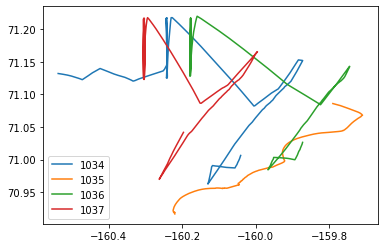

In [16]:
#plot the usv tracks
for iusv in range(4):
    plt.plot(ds_usv.lon[:,iusv],ds_usv.lat[:,iusv],label=ds_usv.trajectory[iusv].data)
plt.legend()

https://eocloud.sentinel-hub.com/v1/wms/1180d546-51af-442e-9a06-d490007ab3a5?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-23%2F2019-06-26&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-17934019%2C11128804%2C-17666552%2C11944360&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=2935&HEIGHT=1401&NICENAME=S1.png&TRANSPARENT=0&BGCOLOR=00000000
0.0 2935.0 1401.0 0.0
https://eocloud.sentinel-hub.com/v1/wms/1180d546-51af-442e-9a06-d490007ab3a5?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-23%2F2019-06-26&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-17934019%2C11128804%2C-17666552%2C11944360&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=2935&HEIGHT=1401&NICENAME=S1.png&TRANSPARENT=0&BGCOLOR=00000000
0.0 2935.0 1401.0 0.0
https://eocloud.sentinel-hub.com/v1/wms/1180d546-51af-442e-9a06-d490007ab3a5?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-23%2F2019-06-26&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-17934019%2C11128804%2C-17666552%2C11944360&evalscripto

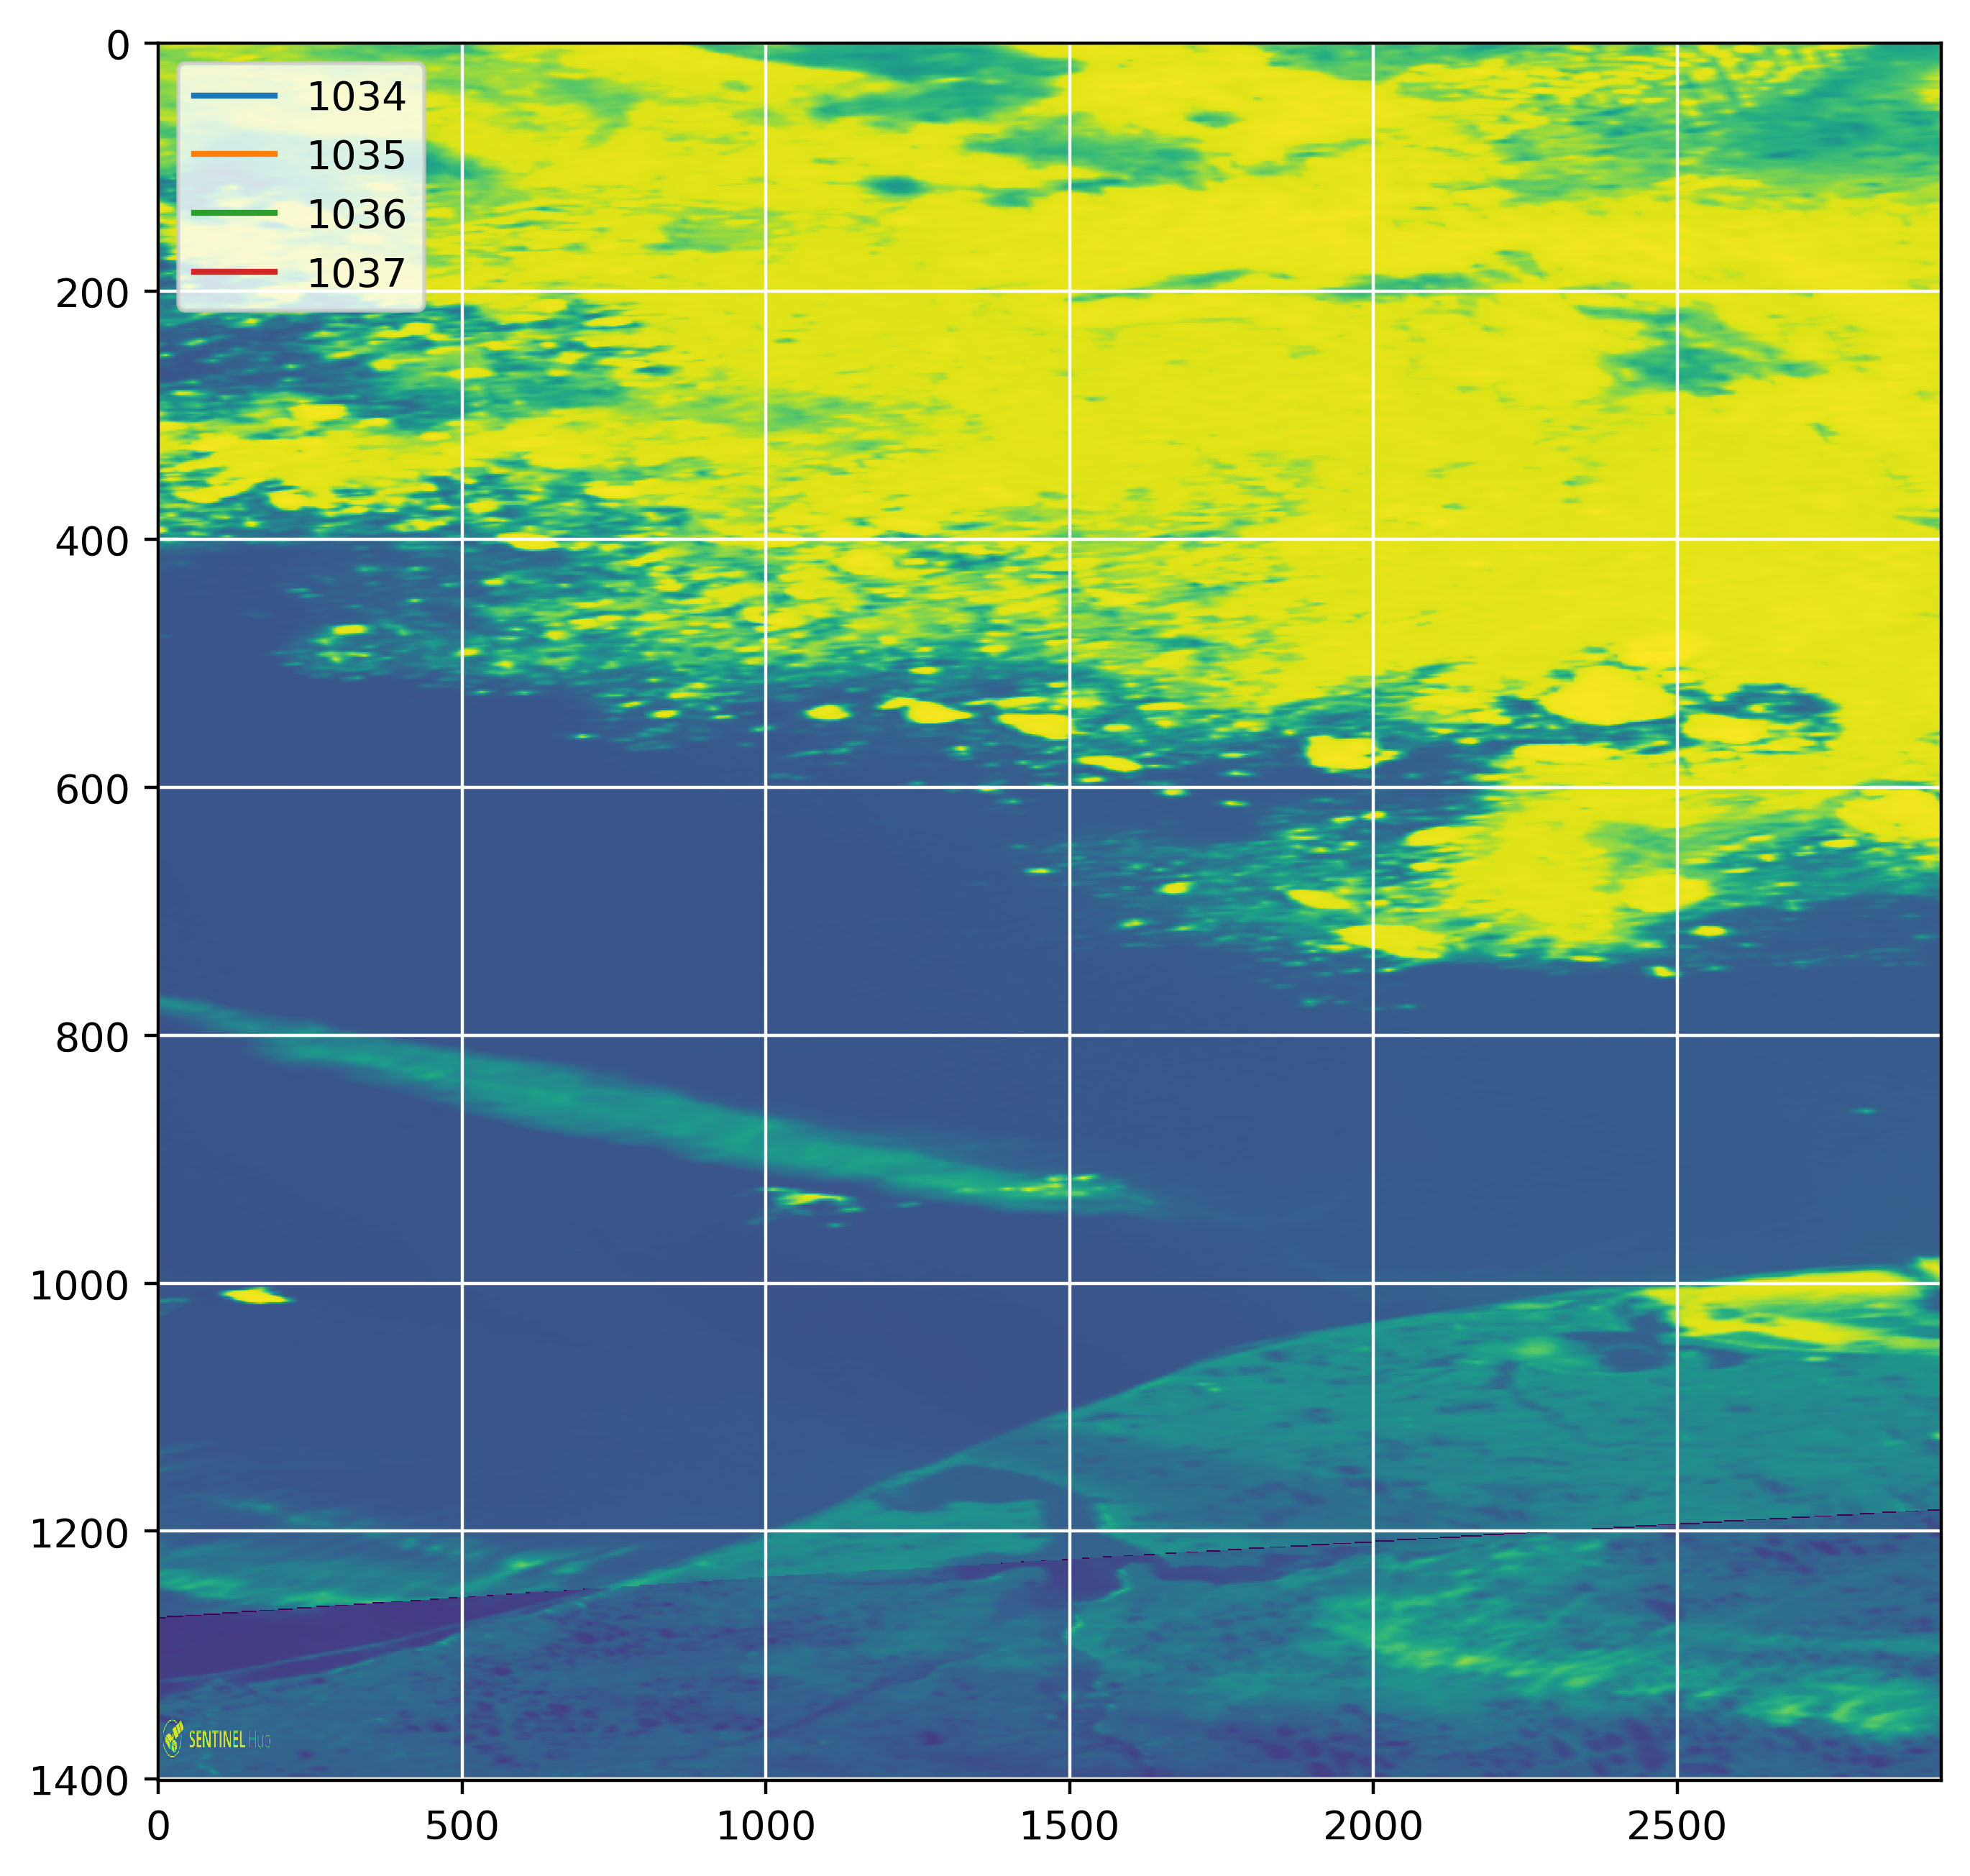

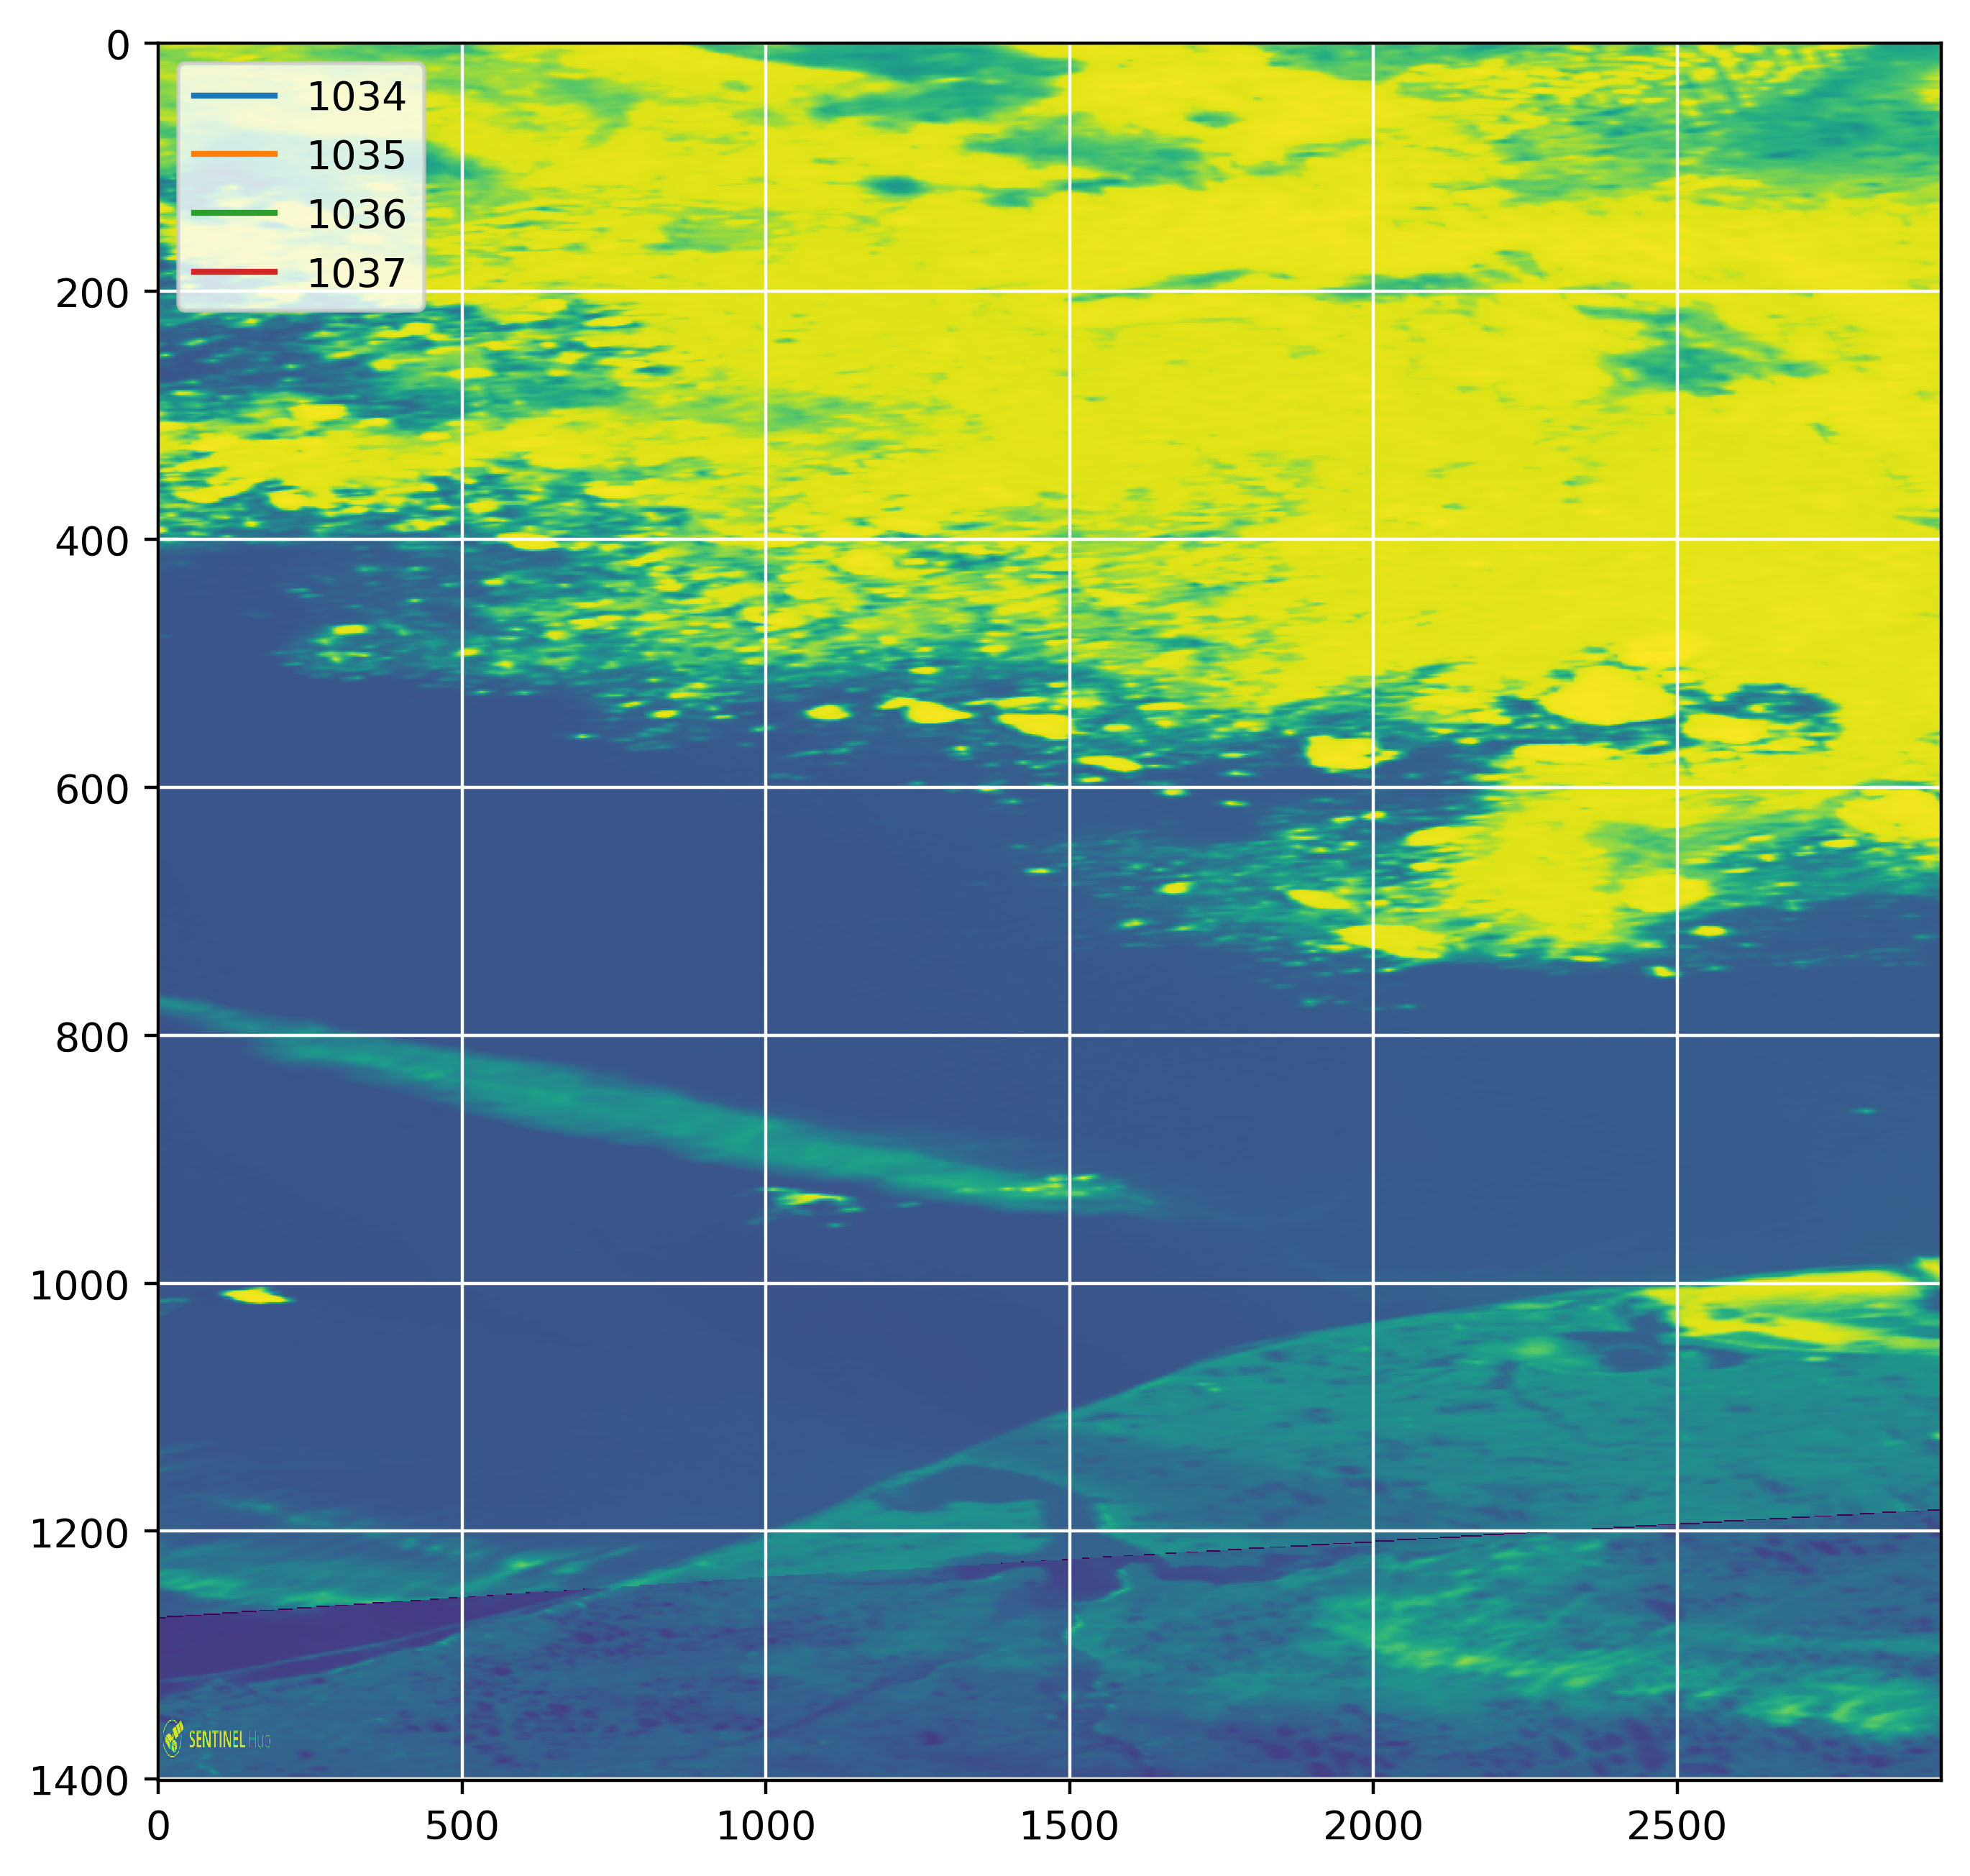

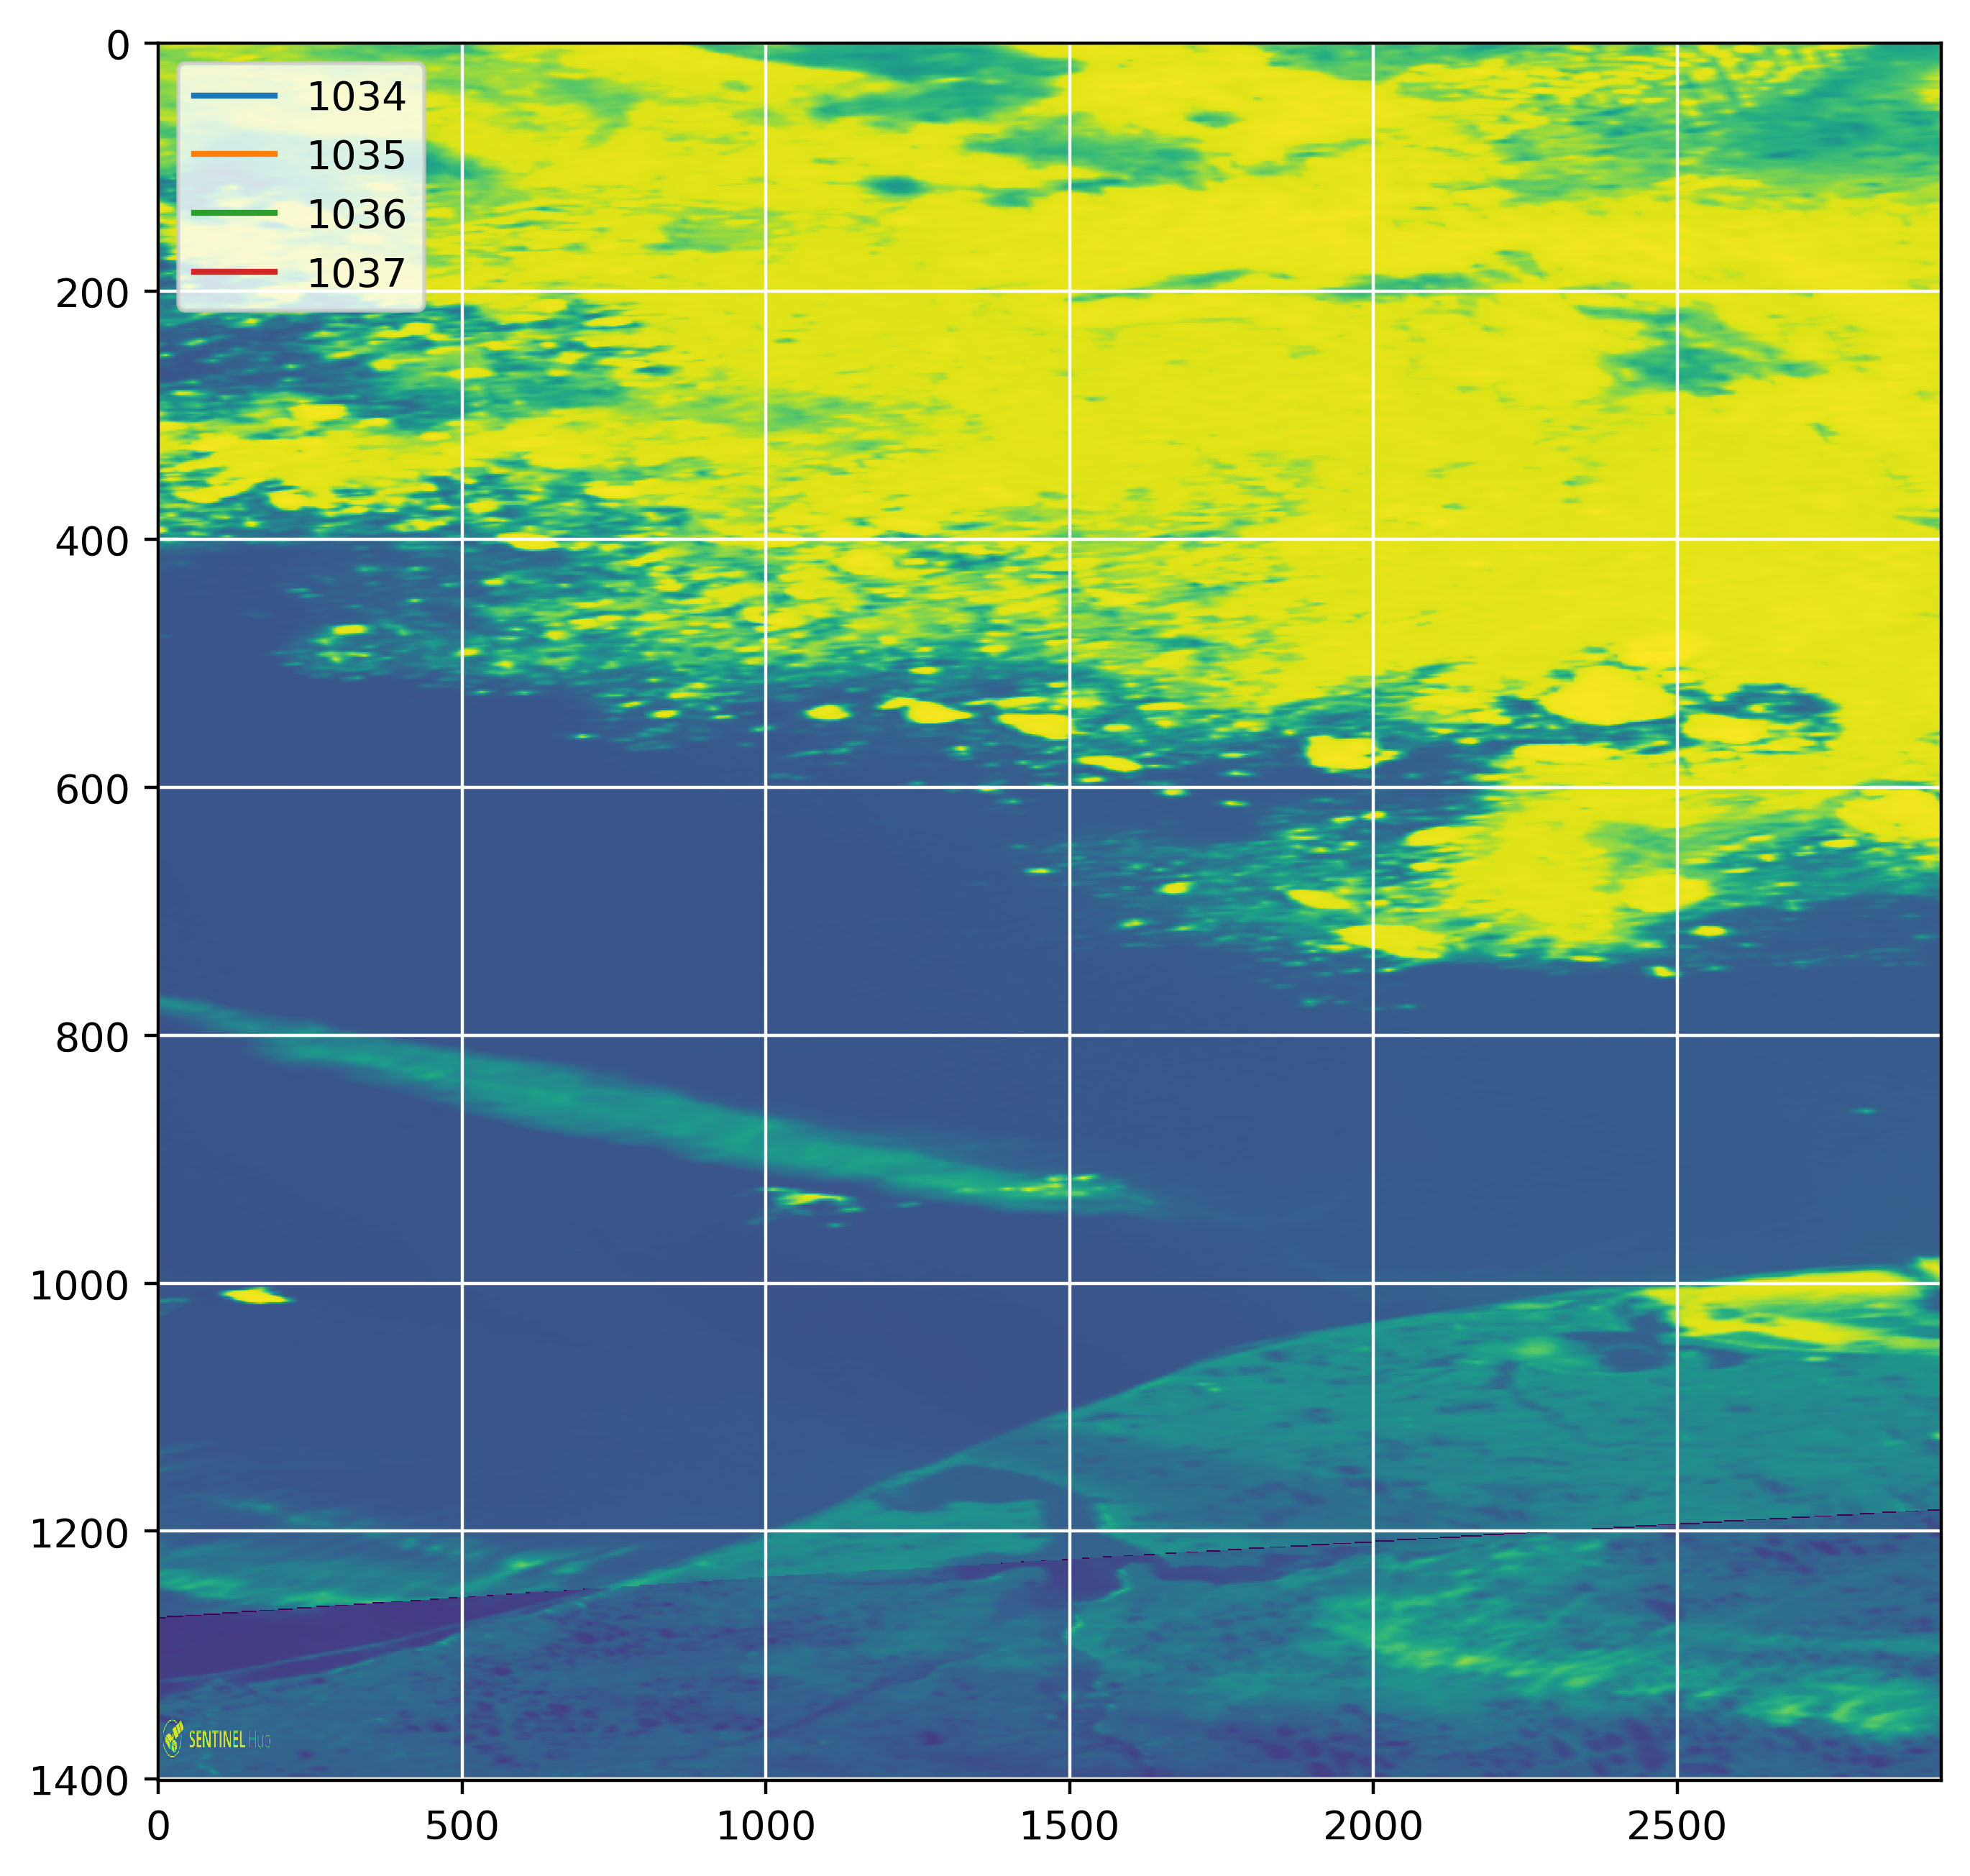

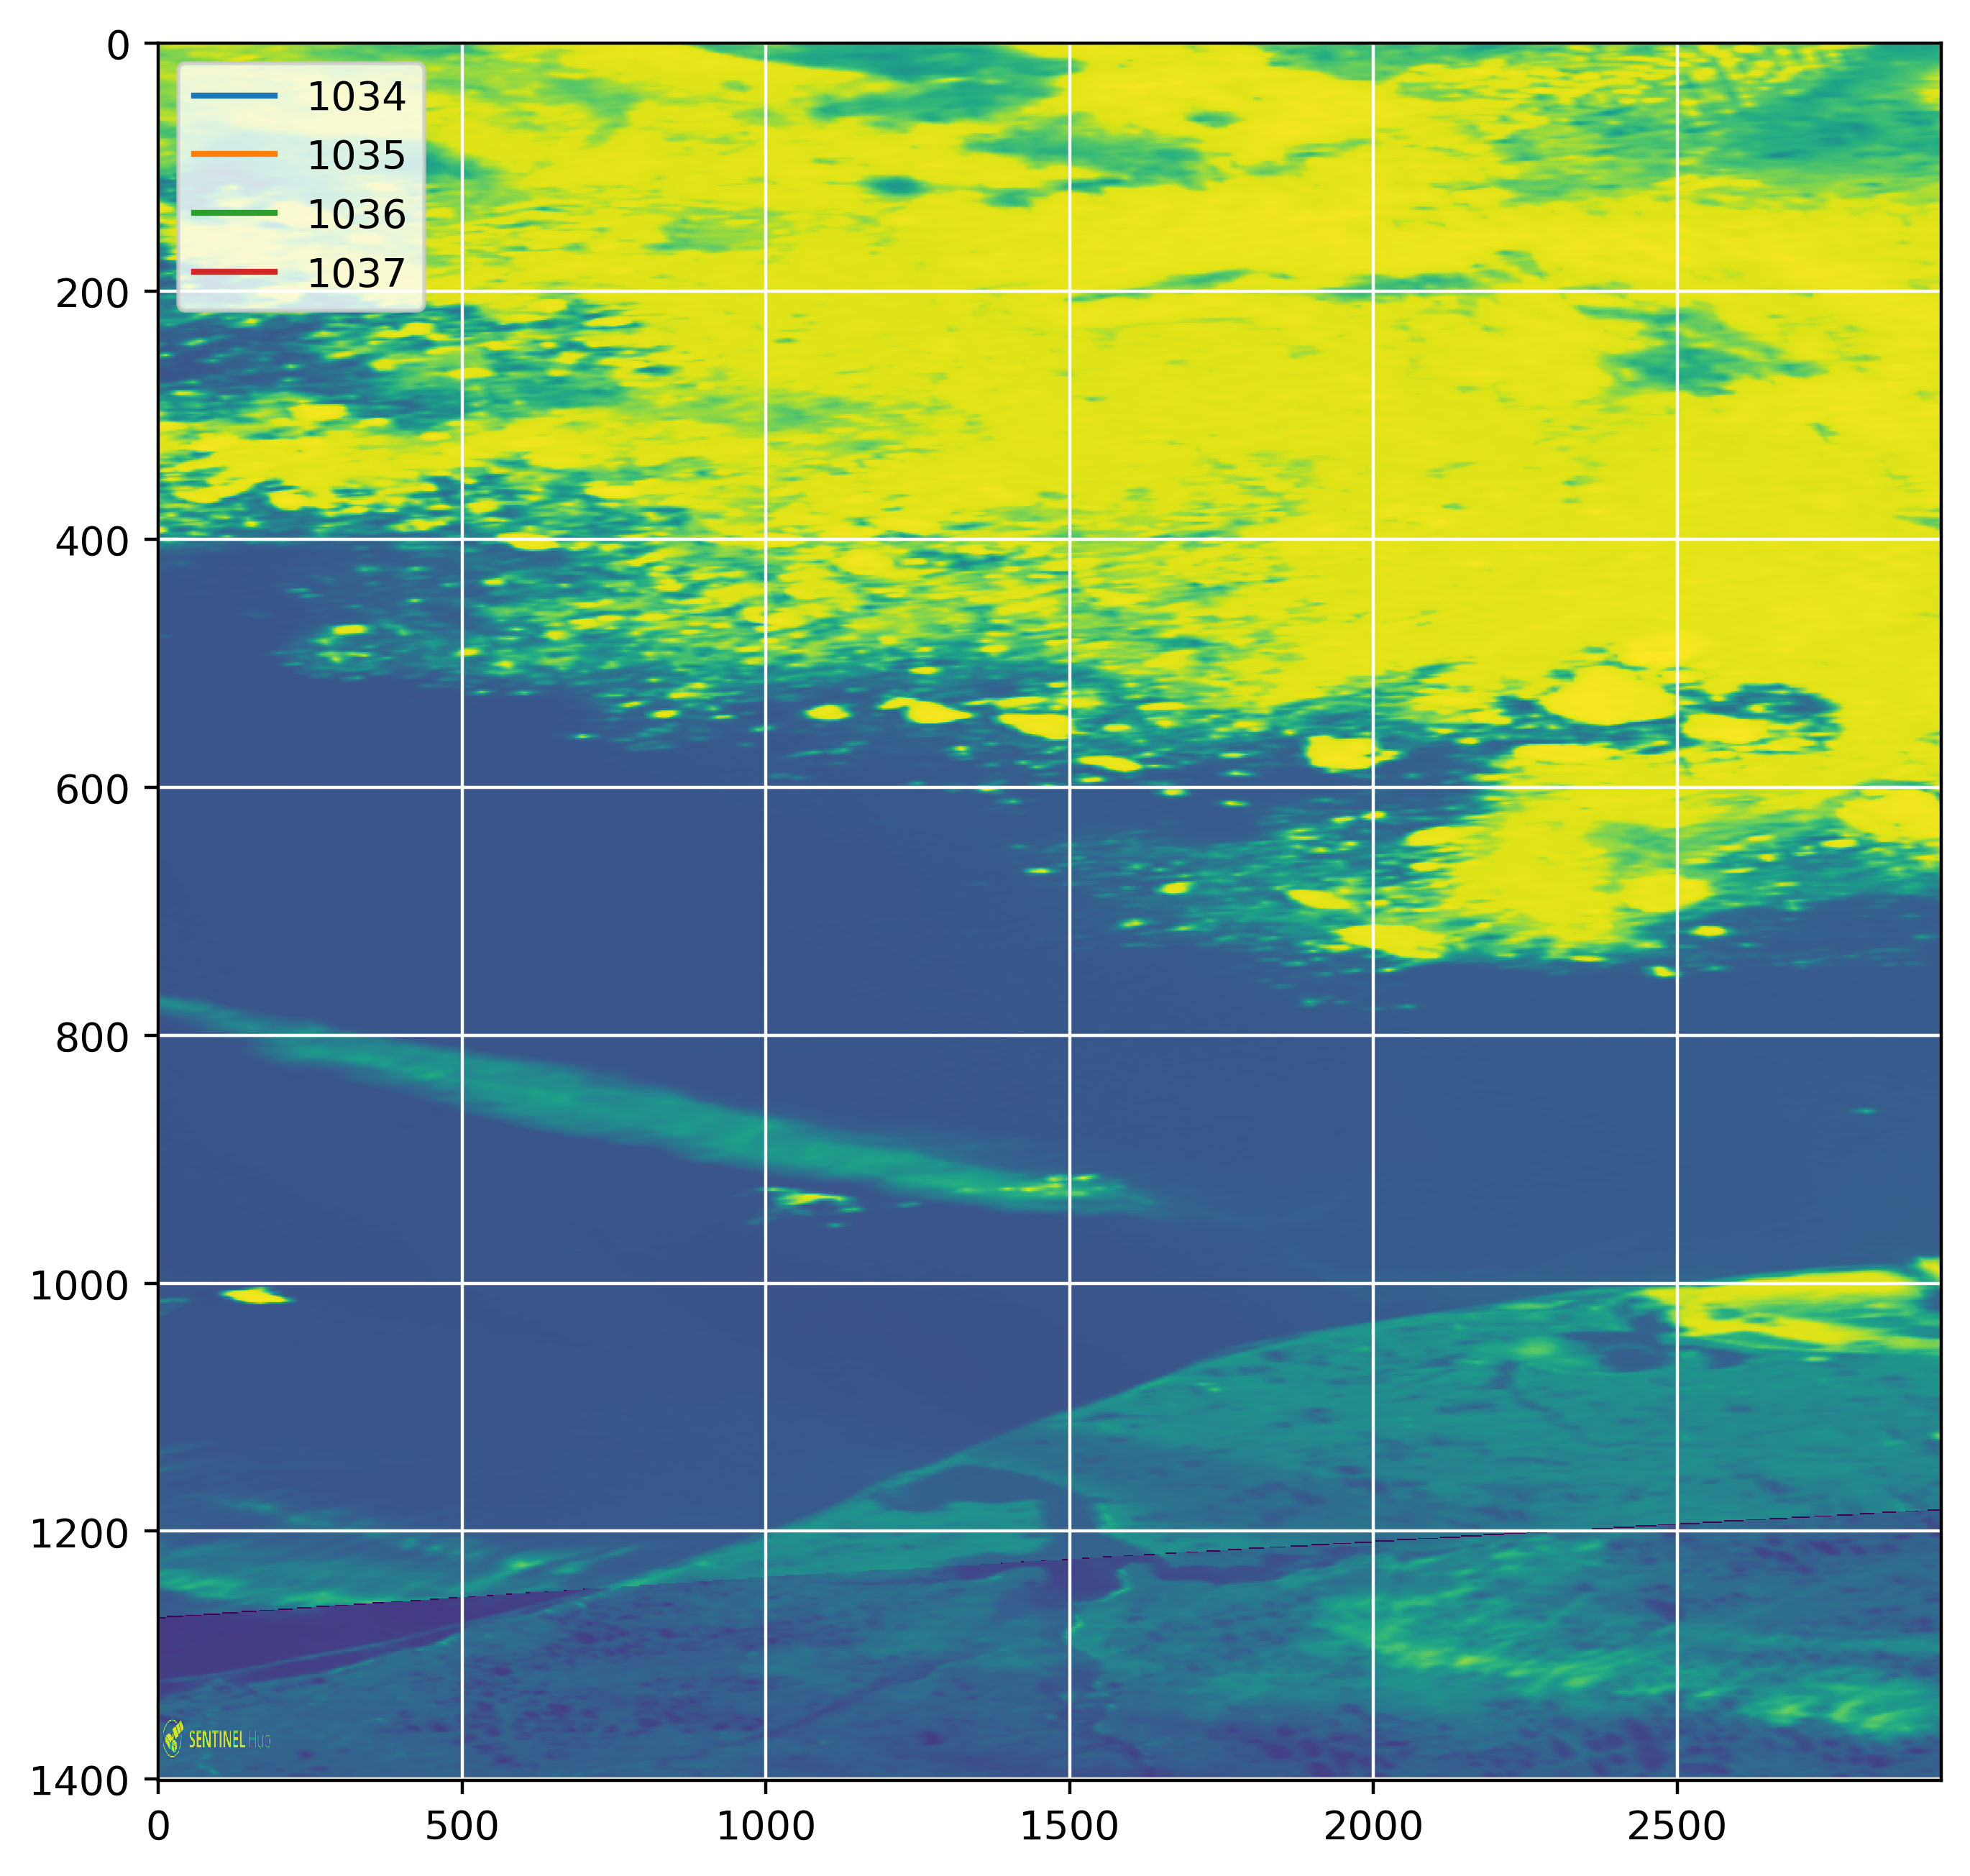

In [18]:
#endtime = datetime.today().strftime('%Y-%m-%d')
endtime = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
starttime = (datetime.today() + timedelta(days=-5)).strftime('%Y-%m-%d')
#use usv data to calculate bounding box
for iusv in range(4):
    subset = ds_usv.isel(trajectory=iusv)
    subset = subset.where(np.isfinite(subset.lon),drop=True)
    lonmin,lonmax = str(subset.lon[0].data-1),str(subset.lon[0].data+1)
    latmin,latmax = str(subset.lat[0].data-1),str(subset.lat[0].data+1)
    #print(lonmin,lonmax,latmin,latmax)
#    url = 'https://services.sentinel-hub.com/ogc/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX='+latmax+'%2C'+lonmax+'%2C'+latmin+'%2C'+lonmin+'&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE' 
    url = 'https://services.sentinel-hub.com/ogc/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX='+latmax+'%2C'+lonmax+'%2C'+latmin+'%2C'+lonmin+'&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE' 
    url = 'https://eocloud.sentinel-hub.com/v1/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-26%2F2019-06-26&CRS=EPSG%3A3857&FORMAT=image%2Ftiff%3Bdepth%3D32f&BBOX=-19164303%2C10971589%2C-16835703%2C12069589&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=3881&HEIGHT=1830&NICENAME=Sentinel-3+OLCI+from+2019-06-26.tiff&COVERAGE'
    url = 'https://eocloud.sentinel-hub.com/v1/wms/1180d546-51af-442e-9a06-d490007ab3a5?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-23%2F2019-06-26&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-17934019%2C11128804%2C-17666552%2C11944360&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=2935&HEIGHT=1401&NICENAME=S1.png&TRANSPARENT=0&BGCOLOR=00000000'
    print(url)
    urllib.request.urlretrieve(url,'S11.tiff')  
    #Open S1 ice file
    driver=gdal.GetDriverByName('GTiff')
    driver.Register() 
    ds = gdal.Open('S11.tiff') 
    if ds is None:
        print('Could not open the Copernicus Sentinel-1 ice data')
    geotransform = ds.GetGeoTransform()
    cols = ds.RasterXSize 
    rows = ds.RasterYSize 
    xmin=geotransform[0]
    ymax=geotransform[3]
    xmax=xmin+cols*geotransform[1]
    ymin=ymax+rows*geotransform[5]
#    xmin=geotransform[0]
#    ymax=geotransform[3]
#    xmax=xmin+cols*geotransform[1]
#    ymin=ymax+rows*geotransform[5]
    centerx=(xmin+xmax)/2
    centery=(ymin+ymax)/2

    #Raster convert to array in numpy
    bands = ds.RasterCount
    band=ds.GetRasterBand(1)
    dataimage= band.ReadAsArray(0,0,cols,rows)

    print(xmin,xmax,ymin,ymax)
    xx=xmin+np.arange(dataimage.shape[1])/dataimage.shape[1]*(xmax-xmin)
    yy=ymin+np.arange(dataimage.shape[0])/dataimage.shape[0]*(ymax-ymin)
    #print(xx.shape,yy.shape)
    #print(xx[0],xx[-1],yy[0],yy[-1])
    fig = plt.figure(figsize=(8, 8), dpi=400)
    plt.pcolormesh(xx,yy,dataimage[-1:0:-1,:])# ,vmin=10,vmax=200)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    for itrag in range(0,ds_usv.trajectory.size):
        subset = ds_usv.isel(trajectory=itrag)
        subset = subset.where(np.isfinite(subset.lon),drop=True)
        plt.plot(subset.lon,subset.lat,label=str(ds_usv.trajectory[itrag].data))
    plt.grid(color='w')
    plt.legend(loc=2)
        #plt.colorbar()
    fig_fname = 'C:/Users/gentemann/Google Drive/public/Saildrone/arctic_zoom_'+str(ds_usv.trajectory[iusv].data)+'_'+str(endtime)+'.png'
    plt.savefig(fig_fname, transparent=False, format='png',dpi=400)
    

In [10]:
geotransform

(-19164303.0, 600.0, 0.0, 12069589.0, 0.0, -600.0)